# Lab 4 - Comparing Classification Models



---















In this session, we demonstrate how to solve a text classification task using simple 
feedforward neural network classifier. We will use IMDB Large Movie Review Dataset to train a binary classification model, able to predict whether a review is positive or negative. First, our network takes one-hot word vectors as input, averages them to make one vector and trains a 
fully-connected layer to predict the output. In the second part, we replace the one-hot vectors with the word embeddings and add a layer to see how much that improves the performance.

We are going to use Keras Sequential API in this session. The Sequential API allows you to make models layer-by-layer. But it is not straightforward to define models where layers connect to more than just the previous and next layers. 

In [1]:
import keras
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt


### Downloading data

The dataset we will be using is the IMDB Large Movie Review Dataset, which consists of 50000 labeled movie reviews. These are split into 25,000 reviews for training and 25,000 reviews for testing. The  dataset contains an even number of positive and negative reviews, so randomly guessing yields 50% accuracy. The data is preprocessed. For text classification, it is ususal to limit the size of the vocabulary to stop the dataset from becoming too sparse, creating possible overfitting. We keep the top 10,000 most frequently occurring words in the training data.


In [2]:
imdb = keras.datasets.imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

We now can start playing around with the data, let’s first see the length:

In [3]:
print("Training entries: {}, labels: {}".format(len(X_train), len(y_train)))

Training entries: 25000, labels: 25000


The  reviews have been converted to integers and each integer represents a  word in a dictionary. 

In [4]:
 X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

We can convert integers back to words by querying a dictionary object that contains the integer to string mapping:

In [5]:
word_index = imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


Index 1 represents the beginning of the sentence and the index 2 is assigned to all unknown tokens. Index 0 will be used for padding.

In [7]:
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<UNUSED>"] = 3

To reverse key and values in a dictionary:

In [8]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

To view a word:

In [9]:
reverse_word_index[25]

'film'

And to recreate the whole sentence from our training data we define decode_review:


In [10]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [11]:
decode_review(X_train[10])

"<START> york seems went about two scenes the ? lunatic little ? anything next the now was people characters why this co ? <UNK> killing <UNK> movie and ? here <UNK> <UNK> ? lunatic like party for ahead lost ? josh little because turned seems warned ? a pass have the ? never york seems characters show him <UNK> i stories excellent movie ? use men for in a him more that to bit there team were have one ? freeman the ? with ? in to seemed a <UNK> one ? special totally ? life it jealousy ? with a ? recall ? many alice movie think worth outside company ? war ex ? government watch a ? your surprised <UNK> aspects and company that faded are a place to ? sleeping was wasn't human ? rude wood <UNK> started element <UNK> unwilling ? not usa fascinating ambitions could ? used these to ? sleeping job at scheming entertainment ? hoped set to ? system it slowly all though <UNK> could <UNK> going the is at genre derek most aka pop ? derek at between his side and enjoy is and potential go ? company hy

### Creating One-hot word vectors

It is  common to use one-hot representation as input in Natural Language Processing tasks. In Keras, the Embedding layer takes an index as an input and convert it to one-hot vector with the length of the vocabulary size. Then multiplies these vectors by a normal weight matrix. But there is no way to only get a one-hot vector as the output of a layer in Keras. To solve this we use Lambda() layer and a function that creates the one-hot layer. 

In [12]:
def OneHot(input_dim=None, input_length=None):
    
    if input_dim is None or input_length is None:
        raise TypeError("input_dim or input_length is not set")

    
    def _one_hot(x, num_classes):
        return K.one_hot(K.cast(x, 'uint8'),
                          num_classes=num_classes)

    return Lambda(_one_hot,
                  arguments={'num_classes': input_dim},
                  input_shape=(input_length,))

input_dim refers to the length of the one-hot vector and input_length refers to the length of the input sequence. Since the input to K.one_hot should be an integer tensor, we cast x to one (Keras passes around float tensors by default).



 Each text sequence has in most cases different length of words. Here, we fill sequences with a pad token (0) to fit the size. This special tokens is then masked not to be accounted in averaging, loss calculation etc. We set the maximum length to 256.

### Preparing input data

In [13]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 256

X_train_enc = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

X_test_enc = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

And to view a padded review:

In [14]:
print(X_train_enc[1])
print('\nLength: ',len(X_train_enc))

[   1  194 1153  194 8255   78  228    5    6 1463 4369 5012  134   26
    4  715    8  118 1634   14  394   20   13  119  954  189  102    5
  207  110 3103   21   14   69  188    8   30   23    7    4  249  126
   93    4  114    9 2300 1523    5  647    4  116    9   35 8163    4
  229    9  340 1322    4  118    9    4  130 4901   19    4 1002    5
   89   29  952   46   37    4  455    9   45   43   38 1543 1905  398
    4 1649   26 6853    5  163   11 3215    2    4 1153    9  194  775
    7 8255    2  349 2637  148  605    2 8003   15  123  125   68    2
 6853   15  349  165 4362   98    5    4  228    9   43    2 1157   15
  299  120    5  120  174   11  220  175  136   50    9 4373  228 8255
    5    2  656  245 2350    5    4 9837  131  152  491   18    2   32
 7464 1212   14    9    6  371   78   22  625   64 1382    9    8  168
  145   23    4 1690   15   16    4 1355    5   28    6   52  154  462
   33   89   78  285   16  145   95    0    0    0    0    0    0    0
    0 

Now we want to build the neural network model. We  are going to have a hidden layer with 16 hidden units. 

First, we want to transform each index to an embedded vector and then average all vectors to a single one. It has been showed that unweighted average of word vectors outperforms many complicated networks that model semantic and syntactic compositionality. As an example you can take a look at this: (http://anthology.aclweb.org/P/P15/P15-1162.pdf)

To average we need to ignore padded zeros:

In [15]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)


# Model 1: Neural averaging network using one-hot vectors

The first layer is an one-hot layer. The second layer is to compute average on all word vectors in a sentence without considering padding. The  output vector is piped through a fully-connected layer. The last layer is connected with a single output node with the sigmoid activation function. The final value is a float between 0 and 1. 
The vocabulary count of the movie reviews (10000) is used as the input shape. At the end we visualize the model summary.

In [16]:
# Created a model with one hot encoded first layer and then took the global average. After that there are 2 dense layers that follow.
from keras.layers import Input, Embedding, Dense, LSTM
from keras.models import Model
from keras.layers import Dot, Input
input_review = Input ( (MAX_SEQUENCE_LENGTH, ), dtype='int32')

review_onehot = OneHot(input_dim = VOCAB_SIZE, input_length = MAX_SEQUENCE_LENGTH)(input_review)

layer2 = GlobalAveragePooling1DMasked() (review_onehot)

layer3 = Dense(16, activation='sigmoid') (layer2)

label = Dense(1, activation = 'sigmoid') (layer3)

model = Model (inputs=[input_review], outputs=[label])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
lambda (Lambda)              (None, 256, 10000)        0         
_________________________________________________________________
global_average_pooling1d_mas (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


### Training the model

To compile the model we need a loss function and an optimizer. We use binary_crossentropy loss function which is just a special case of categorical cross entropy. We also use Adam optimizer that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data. You can read more about it here:
(https://arxiv.org/abs/1412.6980v8
)


In [17]:
# Compiled the model taking adam as the optimizer and loss as binary crossentropy
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])

When training, we want to check the accuracy of the model on data it hasn't seen before. So we create a validation set:

In [18]:
X_val = np.array(X_train_enc[:10000])
partial_X_train = np.array(X_train_enc[10000:])

y_val = np.array(y_train[:10000])
partial_y_train = np.array(y_train[10000:])

Then we start to train the model for 40 epochs in mini-batches of 512 samples and monitor the model's loss and accuracy on the validation set.

In [ ]:
#Fit the data for the x_train and y_train data
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 5s 112ms/step - loss: 0.7661 - accuracy: 0.4996 - val_loss: 0.7242 - val_accuracy: 0.5053
Epoch 2/40
30/30 [==============================] - 3s 106ms/step - loss: 0.7185 - accuracy: 0.5005 - val_loss: 0.7005 - val_accuracy: 0.5053
Epoch 3/40
30/30 [==============================] - 3s 106ms/step - loss: 0.7004 - accuracy: 0.4948 - val_loss: 0.6937 - val_accuracy: 0.5053
Epoch 4/40
30/30 [==============================] - 3s 106ms/step - loss: 0.6937 - accuracy: 0.5002 - val_loss: 0.6927 - val_accuracy: 0.5053
Epoch 5/40
30/30 [==============================] - 3s 106ms/step - loss: 0.6928 - accuracy: 0.5140 - val_loss: 0.6925 - val_accuracy: 0.5102
Epoch 6/40
30/30 [==============================] - 3s 106ms/step - loss: 0.6923 - accuracy: 0.5264 - val_loss: 0.6923 - val_accuracy: 0.5157
Epoch 7/40
30/30 [==============================] - 3s 106ms/step - loss: 0.6920 - accuracy: 0.5146 - val_loss: 0.6920 - val_accuracy: 0.5146
Epoch 

### Evaluating the model

To evaulate the model on test data:

In [ ]:
results = model.evaluate(X_test_enc, y_test)

782/782 [==============================] - 4s 6ms/step - loss: 0.6765 - accuracy: 0.6873


In [ ]:
print(results)
# loss is about 68%, accuracy is about 68%

[0.6764910817146301, 0.687279999256134]


Our first model accuracy using one-hot vectors is ~68%







### Plotting the accuracy graph

To plot a graph of accuracy and loss over time we can use Matplotlib:

In [ ]:
pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.27-cp37-none-any.whl size=7332 sha256=614f0ddf2b19a1696852cf5b094e94d9117efe884d235526e4378e4fdd86c200
  Stored in directory: /root/.cache/pip/wheels/38/9e/e3/6cde1b6b6141b044c692d88980f26c4fe7806cc92ddd009c8c
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.24-cp37-none-any.whl size=6999 sha256=fa8c01df74fc4d3e9faf9178f1fa06ef9698c87633b1399adc595ff0da8506e8
  Stored in directory: /root/.cache/pip/wheels/0c/3b/5d/f2fb3eff7f2fe268463b91a825816a07cd8458c4fe359f034a
  Created wheel for compress-json: filename=compress_json-1.0.4-cp37-none-any.whl size=4586 sha256=884fd19dd8b054504202637a1229c1c0f5b6e77f3fa969a4bfac5d80775da26d
  Stored in directory: /root/.cache/pip/wheels/83/ec/21/51460dd508e4a152c0643946c21fae84eb3391171164d35745
Successfully built plot-keras-history sanitize-ml-labels compress-json


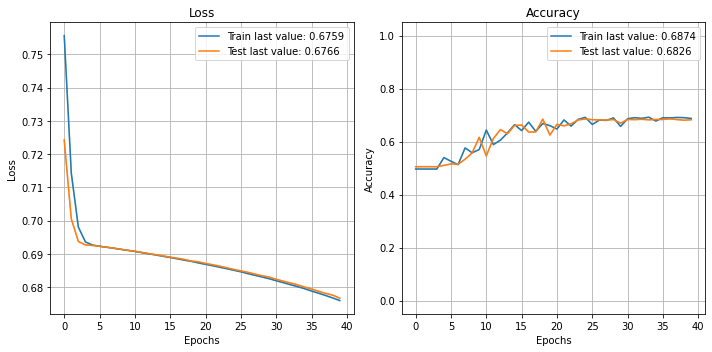

In [ ]:
# Plotted the graph for accuracy and loss over training and validation data
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

# Model 2: Neural averaging network using embedding layer

Now instead of one-hot vectors, we want to use embedding. We change our first layer in model1 to an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

In [19]:
# Created another model with embedding layer
input_review = Input ( (MAX_SEQUENCE_LENGTH, ), dtype='int32')
EMBED_SIZE = 100
review_onehot = Embedding(VOCAB_SIZE, EMBED_SIZE, name='target_embed_layer', input_length = MAX_SEQUENCE_LENGTH)(input_review)
layer2 = GlobalAveragePooling1DMasked() (review_onehot)

layer3 = Dense(16, activation='sigmoid') (layer2)

label = Dense(1, activation = 'sigmoid') (layer3)

model = Model (inputs=[input_review], outputs=[label])
model.summary()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
target_embed_layer (Embeddin (None, 256, 100)          1000000   
_________________________________________________________________
global_average_pooling1d_mas (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,001,633
Trainable params: 1,001,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
30/30 [==============================] - 4s 45ms/step - loss: 0.7118 - accuracy: 0.4989 - val_loss: 0.69

In [20]:
#Evaluated on the test data, got 87% accuracy
results = model.evaluate(X_test_enc, y_test)

782/782 [==============================] - 1s 2ms/step - loss: 0.3376 - accuracy: 0.8716


In [21]:
print (results)

[0.33763137459754944, 0.8715999722480774]


In [23]:
pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.27-cp37-none-any.whl size=7332 sha256=d1b41e4afae61fd5499b377d9d41cd6b6612e4b2d5cacedd2a4a5dbea7208845
  Stored in directory: /root/.cache/pip/wheels/38/9e/e3/6cde1b6b6141b044c692d88980f26c4fe7806cc92ddd009c8c
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.24-cp37-none-any.whl size=6999 sha256=1a478f020f2a99f5aefd091385ec8160cf2eaeebddb74858717b52d83d05b8ca
  Stored in directory: /root/.cache/pip/wheels/0c/3b/5d/f2fb3eff7f2fe268463b91a825816a07cd8458c4fe359f034a
  Created wheel for compress-json: filename=compress_json-1.0.4-cp37-none-any.whl size=4586 sha256=14ac42db11085dcbfc950c02c79f98d26816db4f8ffb9408263f4aaa173fadc8
  Stored in directory: /root/.cache/pip/wheels/83/ec/21/51460dd508e4a152c0643946c21fae84eb3391171164d35745
Successfully built plot-keras-history sanitize-ml-labels compress-json


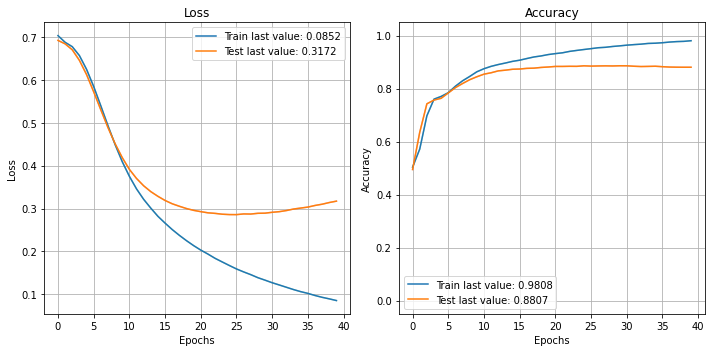

In [24]:
# Plotted the graph for accuracy and loss over training and validation data
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

The accuracy of model2 is 87%. Using Embedding layer instead of one-hot layer improved the performance.

# Model 3: Using pre-trained word embeddings

### Preparing pre-trained word embeddings (GLOVE)

The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings, which you can read about it here (https://nlp.stanford.edu/projects/glove/). GloVe stands for "Global Vectors for Word Representation". It's a somewhat popular embedding technique based on factorizing a matrix of word co-occurence statistics. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.
First, we need to read GloVe and map words to GloVe:


In [25]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [26]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [27]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2021-03-04 07:48:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-04 07:48:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-04 07:48:52--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

We freeze the weights. To create the model: 

In [28]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)
#Created an embedding layer with istrainable = True to get all trainable params
embeddingLayer2=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)

Size of Embedding:  300


## Model 3-1: Neural bag of words using pre-trained word embeddings

Now we change our model to use GloVe:

In [29]:
# Inspect model performance with 1 hidden layer, pre-trained embeddings
# Model created with glove input
input_review = Input ( (MAX_SEQUENCE_LENGTH, ), dtype='int32')
glove_embed = embeddingLayer(input_review)
layer2 = GlobalAveragePooling1DMasked() (glove_embed)

layer3 = Dense(16, activation='sigmoid') (layer2)

label = Dense(1, activation = 'sigmoid') (layer3)

model = Model (inputs=[input_review], outputs=[label])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 256, 300)          120000300 
_________________________________________________________________
global_average_pooling1d_mas (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                4816      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 120,005,133
Trainable params: 4,833
Non-trainable params: 120,000,300
_________________________________________________________________


In [30]:
# Train and test the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 45ms/step - loss: 0.6924 - accuracy: 0.5125 - val_loss: 0.6887 - val_accuracy: 0.5592
Epoch 2/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6884 - accuracy: 0.5578 - val_loss: 0.6849 - val_accuracy: 0.5799
Epoch 3/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6834 - accuracy: 0.5911 - val_loss: 0.6816 - val_accuracy: 0.5897
Epoch 4/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6797 - accuracy: 0.5953 - val_loss: 0.6786 - val_accuracy: 0.5897
Epoch 5/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6775 - accuracy: 0.5963 - val_loss: 0.6763 - val_accuracy: 0.5956
Epoch 6/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6755 - accuracy: 0.5989 - val_loss: 0.6736 - val_accuracy: 0.5977
Epoch 7/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6720 - accuracy: 0.6102 - val_loss: 0.6713 - val_accuracy: 0.6010
Epoch 8/40
30

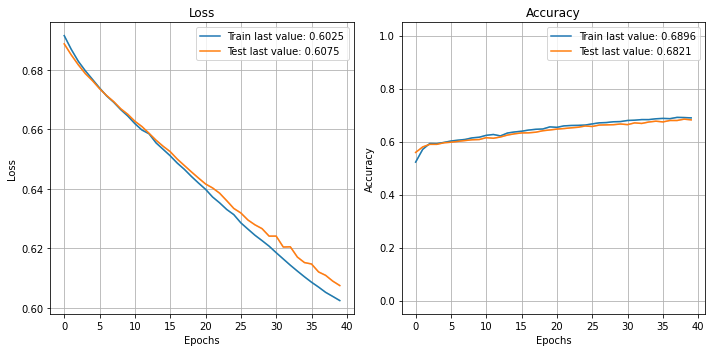

In [31]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

To compare freezing and fine-tuning the pre-train embedding weights, we fine-tune the weights here:

In [32]:
# Another model with fine tuning the pre-train embedding weights in each epoch
input_review = Input ( (MAX_SEQUENCE_LENGTH, ), dtype='int32')
glove_embed = embeddingLayer2(input_review)
layer2 = GlobalAveragePooling1DMasked() (glove_embed)

layer3 = Dense(16, activation='sigmoid') (layer2)

label = Dense(1, activation = 'sigmoid') (layer3)

model3 = Model (inputs=[input_review], outputs=[label])
model3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 256, 300)          120000300 
_________________________________________________________________
global_average_pooling1d_mas (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                4816      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 120,005,133
Trainable params: 120,005,133
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Train and test the model
model3.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
history = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 21s 673ms/step - loss: 0.7941 - accuracy: 0.5046 - val_loss: 0.6960 - val_accuracy: 0.5021
Epoch 2/40
30/30 [==============================] - 19s 642ms/step - loss: 0.6953 - accuracy: 0.5130 - val_loss: 0.6872 - val_accuracy: 0.5300
Epoch 3/40
30/30 [==============================] - 19s 641ms/step - loss: 0.6835 - accuracy: 0.5528 - val_loss: 0.6763 - val_accuracy: 0.6225
Epoch 4/40
30/30 [==============================] - 19s 640ms/step - loss: 0.6712 - accuracy: 0.6554 - val_loss: 0.6629 - val_accuracy: 0.6942
Epoch 5/40
30/30 [==============================] - 19s 644ms/step - loss: 0.6562 - accuracy: 0.7099 - val_loss: 0.6453 - val_accuracy: 0.7132
Epoch 6/40
30/30 [==============================] - 19s 643ms/step - loss: 0.6344 - accuracy: 0.7334 - val_loss: 0.6191 - val_accuracy: 0.7368
Epoch 7/40
30/30 [==============================] - 19s 639ms/step - loss: 0.6052 - accuracy: 0.7508 - val_loss: 0.5861 - val_accuracy: 0.7588

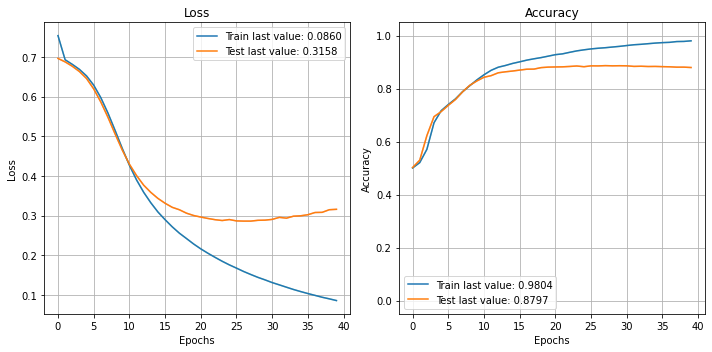

In [34]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

Experiments here show that fine-tuning the pre-trained embeddings would obtain better accuracy.

Note that although fine-tuning the pre-trained embeddings is better here, we do not fine-tune it in other models. You could conduct extra experiments to compare the results.

##  Model 3-2: LSTM with pre-trained word embeddings

In previous labs, we have conducted an experiment based on LSTM. Now, we replace its embeddings with the GloVe pre-trained embeddings.

In [35]:
# LSTM Model with pre-trained word embeddings
input_review = Input ( (MAX_SEQUENCE_LENGTH, ), dtype='int32')
glove_embed = embeddingLayer(input_review)
layer2 = LSTM(100, return_sequences=False)(glove_embed)
label = Dense(1, activation = 'sigmoid') (layer2)
model7 = Model (inputs=[input_review], outputs=[label])
model7.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 256, 300)          120000300 
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 120,160,801
Trainable params: 160,501
Non-trainable params: 120,000,300
_________________________________________________________________


In [36]:
# Train and test the model
model7.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
history = model7.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 31s 113ms/step - loss: 0.6920 - accuracy: 0.5161 - val_loss: 0.6783 - val_accuracy: 0.5429
Epoch 2/40
30/30 [==============================] - 3s 90ms/step - loss: 0.6761 - accuracy: 0.5563 - val_loss: 0.6720 - val_accuracy: 0.5570
Epoch 3/40
30/30 [==============================] - 3s 90ms/step - loss: 0.6486 - accuracy: 0.6185 - val_loss: 0.6513 - val_accuracy: 0.6237
Epoch 4/40
30/30 [==============================] - 3s 90ms/step - loss: 0.6640 - accuracy: 0.5903 - val_loss: 0.6800 - val_accuracy: 0.5336
Epoch 5/40
30/30 [==============================] - 3s 91ms/step - loss: 0.6715 - accuracy: 0.5571 - val_loss: 0.6734 - val_accuracy: 0.5502
Epoch 6/40
30/30 [==============================] - 3s 90ms/step - loss: 0.6588 - accuracy: 0.5843 - val_loss: 0.6496 - val_accuracy: 0.6190
Epoch 7/40
30/30 [==============================] - 3s 90ms/step - loss: 0.6274 - accuracy: 0.6359 - val_loss: 0.6291 - val_accuracy: 0.6335
Epoch 8/40


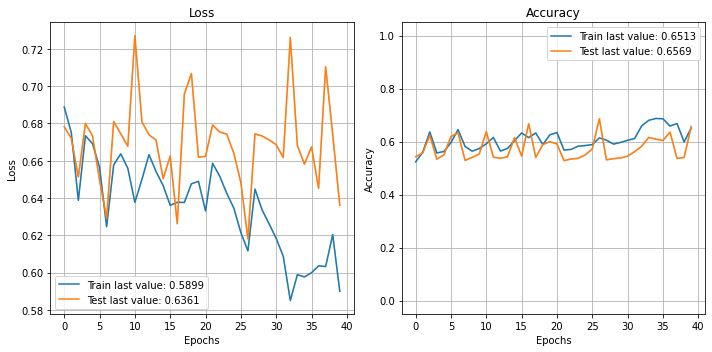

In [37]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

Experiment show that simply replacing the lab 2 model embeddings with pre-trained word embeddings (GloVe) will cause performance to drop significantly. 
What can you do to improve the situation?

#  Model 4: Adding extra dense layer into Neural averaging network model

We add extra dense layers into model 3-1 (neural network model) to evaluate extra dense layers' contribution. We start by adding one layer, then add two. All parameters are the same as model 3-1.

### Adding one extra dense layer

In [38]:
# Inspect model performance with 1 hidden layer, pre-trained embeddings
# Added an extra dense layer
input_review = Input ( (MAX_SEQUENCE_LENGTH, ), dtype='int32')
glove_embed = embeddingLayer(input_review)
layer2 = GlobalAveragePooling1DMasked() (glove_embed)
layer3 = Dense(100, activation='sigmoid') (layer2)
layer4 = Dense(16, activation='sigmoid') (layer3)

label = Dense(1, activation = 'sigmoid') (layer4)

model4 = Model (inputs=[input_review], outputs=[label])
model4.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 256, 300)          120000300 
_________________________________________________________________
global_average_pooling1d_mas (None, 300)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_10 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 120,032,033
Trainable params: 31,733
Non-trainable params: 120,000,300
________________________________________

In [39]:
# Train and test the model
model4.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
history = model4.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 47ms/step - loss: 0.6983 - accuracy: 0.5058 - val_loss: 0.6921 - val_accuracy: 0.5167
Epoch 2/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6906 - accuracy: 0.5467 - val_loss: 0.6892 - val_accuracy: 0.5486
Epoch 3/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6897 - accuracy: 0.5239 - val_loss: 0.6866 - val_accuracy: 0.5860
Epoch 4/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6860 - accuracy: 0.5671 - val_loss: 0.6839 - val_accuracy: 0.5837
Epoch 5/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6825 - accuracy: 0.5872 - val_loss: 0.6803 - val_accuracy: 0.5896
Epoch 6/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6792 - accuracy: 0.5870 - val_loss: 0.6764 - val_accuracy: 0.5933
Epoch 7/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6738 - accuracy: 0.5963 - val_loss: 0.6723 - val_accuracy: 0.5952
Epoch 8/40
30

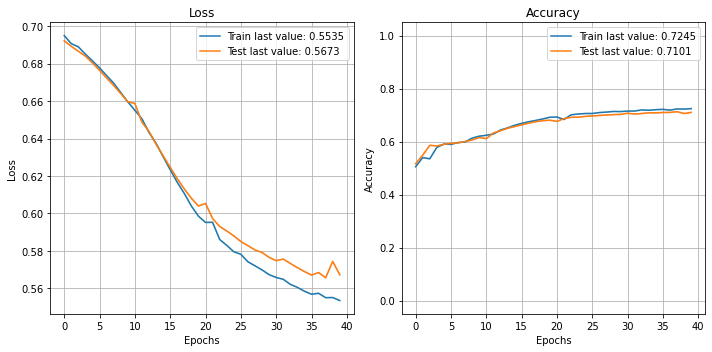

In [40]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

### Adding two extra dense layers

In [41]:
# Inspect model performance with 1 hidden layer, pre-trained embeddings
# Added another dense layer
input_review = Input ( (MAX_SEQUENCE_LENGTH, ), dtype='int32')
glove_embed = embeddingLayer(input_review)
layer2 = GlobalAveragePooling1DMasked() (glove_embed)
layer3 = Dense(300, activation='sigmoid') (layer2)
layer4 = Dense(100, activation='sigmoid') (layer3)
layer5 = Dense(16, activation='sigmoid') (layer4)

label = Dense(1, activation = 'sigmoid') (layer5)

model4 = Model (inputs=[input_review], outputs=[label])
model4.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 256, 300)          120000300 
_________________________________________________________________
global_average_pooling1d_mas (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_14 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17  

In [42]:
# Train and test the model
model4.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
history = model4.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 46ms/step - loss: 0.6952 - accuracy: 0.4999 - val_loss: 0.6929 - val_accuracy: 0.4947
Epoch 2/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6924 - accuracy: 0.5145 - val_loss: 0.6950 - val_accuracy: 0.4947
Epoch 3/40
30/30 [==============================] - 1s 42ms/step - loss: 0.6933 - accuracy: 0.5094 - val_loss: 0.6898 - val_accuracy: 0.5283
Epoch 4/40
30/30 [==============================] - 1s 42ms/step - loss: 0.6900 - accuracy: 0.5270 - val_loss: 0.6886 - val_accuracy: 0.5203
Epoch 5/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6860 - accuracy: 0.5553 - val_loss: 0.6813 - val_accuracy: 0.5822
Epoch 6/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6789 - accuracy: 0.5754 - val_loss: 0.6868 - val_accuracy: 0.5348
Epoch 7/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6779 - accuracy: 0.5630 - val_loss: 0.6667 - val_accuracy: 0.5976
Epoch 8/40
30

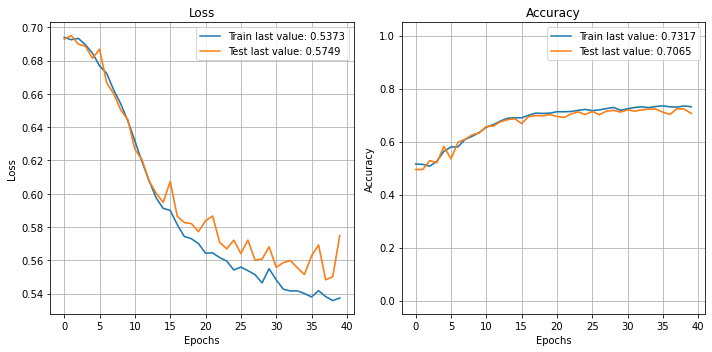

In [43]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

These two experiments show that adding extra dense layers can slightly improve accuracy over model 3-1.

---



#  Model 5: CNN for Text Classification

In this section, we build a Convolutional Neural Network (CNN) for text classification. We start by using one CNN layer and then adding another layer. You could use embeddings from pre-trained or scratch.

##  Model 5-1: Basic CNN model for Text Classification 

In [44]:
hidden_layer=16
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
# Created a model with convolutional layer
input_review = Input ( (MAX_SEQUENCE_LENGTH, ), dtype='int32')
EMBED_SIZE = 300
review_embed = Embedding(VOCAB_SIZE, EMBED_SIZE, name='embed_layer', input_length = MAX_SEQUENCE_LENGTH)(input_review)
#embed = embeddingLayer2(input_review)
cnn = Conv1D(filters = 100, kernel_size = 6,activation = 'relu')(review_embed)
maxp = GlobalAveragePooling1DMasked() (cnn)
label = Dense(1, activation = 'sigmoid') (maxp)

model5 = Model(inputs=[input_review], outputs=[label])
model5.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embed_layer (Embedding)      (None, 256, 300)          3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 251, 100)          180100    
_________________________________________________________________
global_average_pooling1d_mas (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 101       
Total params: 3,180,201
Trainable params: 3,180,201
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Train and test the model
model5.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
history = model5.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 5s 132ms/step - loss: 0.6813 - accuracy: 0.5964 - val_loss: 0.5648 - val_accuracy: 0.7590
Epoch 2/40
30/30 [==============================] - 4s 127ms/step - loss: 0.4795 - accuracy: 0.8038 - val_loss: 0.3364 - val_accuracy: 0.8662
Epoch 3/40
30/30 [==============================] - 4s 126ms/step - loss: 0.2612 - accuracy: 0.9048 - val_loss: 0.2982 - val_accuracy: 0.8811
Epoch 4/40
30/30 [==============================] - 4s 126ms/step - loss: 0.1889 - accuracy: 0.9339 - val_loss: 0.2922 - val_accuracy: 0.8853
Epoch 5/40
30/30 [==============================] - 4s 125ms/step - loss: 0.1362 - accuracy: 0.9596 - val_loss: 0.3054 - val_accuracy: 0.8825
Epoch 6/40
30/30 [==============================] - 4s 126ms/step - loss: 0.1064 - accuracy: 0.9727 - val_loss: 0.3290 - val_accuracy: 0.8796
Epoch 7/40
30/30 [==============================] - 4s 126ms/step - loss: 0.0925 - accuracy: 0.9735 - val_loss: 0.3510 - val_accuracy: 0.8763
Epoch 

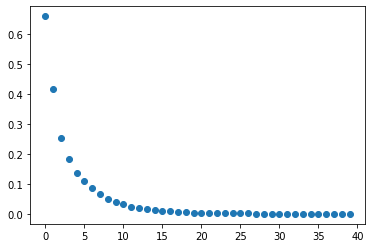

In [46]:
# your code goes here
plt.scatter(history.epoch,history.history['loss'])
plt.show()

## Model 5-2: Adding extra convolutional layer

In [47]:
# Added an extra convolutional layer
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
input_review = Input ( (MAX_SEQUENCE_LENGTH, ), dtype='int32')
EMBED_SIZE = 300
review_embed = Embedding(VOCAB_SIZE, EMBED_SIZE, name='embed_layer', input_length = MAX_SEQUENCE_LENGTH)(input_review)
#embed = embeddingLayer2(input_review)
cnn = Conv1D(filters = 100, kernel_size = 6,activation = 'relu')(review_embed)
cnn1 = Conv1D(filters = 100, kernel_size = 6,activation = 'relu')(cnn)
maxp = GlobalAveragePooling1DMasked() (cnn1)
label = Dense(1, activation = 'sigmoid') (maxp)

model6 = Model(inputs=[input_review], outputs=[label])
model6.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embed_layer (Embedding)      (None, 256, 300)          3000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 251, 100)          180100    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 246, 100)          60100     
_________________________________________________________________
global_average_pooling1d_mas (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 101       
Total params: 3,240,301
Trainable params: 3,240,301
Non-trainable params: 0
_________________________________________________

In [48]:
# Train and test the model
# your code goes here
model6.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
history = model6.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 5s 148ms/step - loss: 0.6826 - accuracy: 0.5341 - val_loss: 0.4680 - val_accuracy: 0.7905
Epoch 2/40
30/30 [==============================] - 4s 142ms/step - loss: 0.3650 - accuracy: 0.8515 - val_loss: 0.3106 - val_accuracy: 0.8714
Epoch 3/40
30/30 [==============================] - 4s 143ms/step - loss: 0.1913 - accuracy: 0.9280 - val_loss: 0.3396 - val_accuracy: 0.8721
Epoch 4/40
30/30 [==============================] - 4s 144ms/step - loss: 0.1284 - accuracy: 0.9584 - val_loss: 0.3527 - val_accuracy: 0.8776
Epoch 5/40
30/30 [==============================] - 4s 145ms/step - loss: 0.0795 - accuracy: 0.9764 - val_loss: 0.4533 - val_accuracy: 0.8606
Epoch 6/40
30/30 [==============================] - 4s 142ms/step - loss: 0.0588 - accuracy: 0.9823 - val_loss: 0.4879 - val_accuracy: 0.8667
Epoch 7/40
30/30 [==============================] - 4s 142ms/step - loss: 0.0312 - accuracy: 0.9931 - val_loss: 0.5844 - val_accuracy: 0.8601
Epoch 

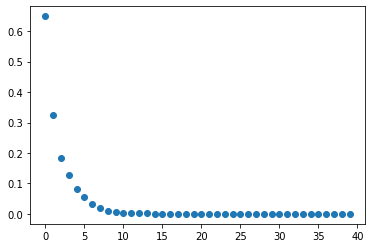

In [49]:
# your code goes here
plt.scatter(history.epoch,history.history['loss'])
plt.show()

Although adding layer here reduces the training loss, the evaluation accuracy is worse than the model without the extra convolutional layer.

Adding more layers can help you to extract more features. But we can do that up to a certain extent. After some point, instead of extracting features, we tend to overfit the data. Overfitting can lead to errors in on form or another, such as false positives. It is not easy to choose the number of units in a hidden layer or the number of hidden layers in a neural network. For many applications, one hidden layer is enough. As a general rule, the number of units in that hidden layer is between the number of inputs and the number of outputs.
 The best way to decide on the number of units and hidden layers is to try various parameters. Train several neural networks with different numbers of hidden layers and neurons, and monitor the performance of them. You will have to experiment using a series of different architectures. 







---

